# 0. Solution Planning

## 0.1. Input

1. Business Problem
    - Select most valuable clientsto be part of a loyalty program

2. Dataset
    - Sales from an e-commerce during one year

## 0.2. Output

1. People indication to be part of the loyalty program
    - List of clients tagged

2. Report with the business questions

    - Who are the elegible people to participate in the loyalty program?
    - How many clients will be part of the loyalty program?
    - Which are the main client characteristics?
    - What is the percentage of profit contribution that comes from the loyalty program?
    - What is the profit expectation from this group in the next months?
    - What are the conditions that makes someone elegible to the loyalty program?
    - What are the conditions that makes someone not elegible anymore to the loyalty program?
    - What are the metrics to decide if the loyalty program people are really better than the rest of the database?
    - What could the marketing team do to improve the profit?

## 0.3. Tasks

Who are the elegible people to participate in the loyalty program?
- High average ticket;
- High LTV (Life Time Value);
- High purchase frequency;
- High basket size;
- Low churn probability;
- High purchase propensity.
- Low number of devolutions;
- Experience;
- High number of ratings.

How many clients will be part of the loyalty program?
- Percentage of total clients.

What are the main client characteristics?
- Important client attributes (age, country, salary);
- Client purchasing behavior.

What is the percentage of profit contribution that comes from the loyalty program?
- Get the total profit of the company during the year and the percentage of the cluster.

What is the profit expectation from this group in the next months?
- Get the loyalty program LTV;
- Build a time series.

What are the conditions that make someone elegible to the loyalty program?
- The average performance of the client is close to the average performance of the clients from the loyalty program.

What are the conditions that make someone not elegible anymore to the loyalty program?
- The client average performance is not close to the loyalty program average anymore.

What are the metrics to decide if the loyalty program people are really better than the rest of the database?
- Hypothesis testing;
- A/B testing.

What could the marketing team do to improve the profit?
- Discounts;
- Choosing preferences;
- Exclusive products.

# 1. Imports

In [1]:
import numpy as np
import regex as re
import pandas as pd
import seaborn as sns
import umap.umap_ as umap

from sklearn import metrics
from quickda import explore_data
from matplotlib import cm
from IPython.display import HTML
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from plotly import express as px
from sklearn import cluster as c
from sklearn import mixture as mx
from sklearn import ensemble as en
from sklearn import manifold as mn
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from matplotlib import pyplot as plt
from scipy.cluster import hierarchy as hc

## 1.1. Helper Functions

In [2]:
def settings():

    %matplotlib inline
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container { width:100% !important; }</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    pd.set_option('display.expand_frame_repr', False)

    sns.set()

settings()

## 1.2. Load Dataset

In [3]:
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='unicode_escape')

df_raw.drop(columns=['Unnamed: 8'], inplace=True)

In [4]:
df_raw.head()

InvoiceNo StockCode                          Description  Quantity InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   29-Nov-16     2.5500  17850.0000  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6   29-Nov-16     3.3900  17850.0000  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   29-Nov-16     2.7500  17850.0000  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   29-Nov-16     3.3900  17850.0000  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   29-Nov-16     3.3900  17850.0000  United Kingdom

# 2. Data Description

In [5]:
df1 = df_raw.copy()

## 2.1. Rename Columns

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 2.2. Data Dimension

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Cols: 8


## 2.3. Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 2.4. Replace NA

In [9]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [10]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [11]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 2.6. Check Data Types

In [12]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

## 2.4. Change Data Types

In [13]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

In [14]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 2.7. Descriptive Statistics

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 2.7.1. Numerical Attributes

In [16]:
num_attributes.head()

quantity  unit_price  customer_id
0         6      2.5500        17850
1         6      3.3900        17850
2         8      2.7500        17850
3         6      3.3900        17850
4         6      3.3900        17850

In [17]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

attributes         min        max       range       mean     median       std     skew    kurtosis
0     quantity -80995.0000 80995.0000 161990.0000     9.5522     3.0000  218.0810  -0.2641 119769.1600
1   unit_price -11062.0600 38970.0000  50032.0600     4.6111     2.0800   96.7598 186.5070  59005.7191
2  customer_id  12346.0000 22709.0000  10363.0000 16688.8405 16249.0000 2911.4087   0.4874     -0.8043

1. Quantity with negative value;

2. Unit price equal to zero.

### 2.7.2. Categorical Attributes

In [18]:
cat_attributes.head()

invoice_no stock_code                          description         country  customer_id
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER  United Kingdom        17850
1     536365      71053                  WHITE METAL LANTERN  United Kingdom        17850
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER  United Kingdom        17850
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE  United Kingdom        17850
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.  United Kingdom        17850

In [19]:
# invoice_no
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

print('Total number of invoices with letters: {}'.format(len(df_letter_invoices)))

print('Total number of negative quantities with letter in the invoice: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity']< 0])))

Total number of invoices with letters: 9291
Total number of negative quantities with letter in the invoice: 9288


In [20]:
# stock_code
print('Number of stock codes with at least one letter: {}'.format(len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'].drop_duplicates())))

print('List of stock codes composed only by letters: {}'.format(df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()))


Number of stock codes with at least one letter: 1124
List of stock codes composed only by letters: ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS'
 'B' 'CRUK']


In [21]:
# country
print('Number of countries in the database: {}'.format(len(df1['country'].unique())))
print('\nSome of these countries: \n{}'.format(df1['country'].value_counts(normalize=True).head(10)))

Number of countries in the database: 38

Some of these countries: 
United Kingdom   0.9143
Germany          0.0175
France           0.0158
EIRE             0.0151
Spain            0.0047
Netherlands      0.0044
Belgium          0.0038
Switzerland      0.0037
Portugal         0.0028
Australia        0.0023
Name: country, dtype: float64


# 3. Variable Filtering

In [22]:
df2 = df1.copy()

In [23]:
# unit price
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# stock_code
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] >= 0, :]

# 4. Feature Engineering

In [24]:
df3 = df2.copy()

## 4.1. Feature Creation

In [25]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1)
df_ref = df_ref.drop_duplicates(ignore_index=True)

### 4.1.1. Gross Revenue

In [26]:
# gross revenue (profit) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# monetary
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

C:\Users\pma2022\AppData\Local\Temp\ipykernel_7316\1551767982.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 4.1.2. Recency

In [27]:
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency.loc[:, ['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

### 4.1.3. Quantity of Purchases

In [28]:
df_freq = df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'q_invoices'})
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

### 4.1.4. Quantity of Items Purchased

In [29]:
df_freq = df2_purchases.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'q_items'})
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

### 4.1.5. Quantity of Products Purchased

In [30]:
df_freq = df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code': 'q_products'})
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

### 4.1.6. Average Ticket Value

In [31]:
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

### 4.1.7. Average Recency Days

In [32]:
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[False, False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['previous_date'] - x['invoice_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')

### 4.1.8. Frequency

In [33]:
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                            .groupby('customer_id')
                                                            .agg(max_ = ( 'invoice_date', 'max'), 
                                                                 min_ = ( 'invoice_date', 'min'),
                                                                 days_= ( 'invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                 buy_ = ( 'invoice_no', 'count'))).reset_index()

df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1)
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

### 4.1.9. Returns

In [34]:
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'q_returns'})
df_returns['q_returns'] = df_returns['q_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['q_returns'].isna(), 'q_returns'] = 0


### 4.1.10. Basket Size

In [35]:
df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id').agg(n_purchases=('invoice_no', 'nunique'),
                                                                                                     n_products=('quantity', 'sum')).reset_index())

df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']

df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')

### 4.1.11. Unique Basket Size

In [36]:
df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id').agg(n_purchases=('invoice_no', 'nunique'),
                                                                                                       n_products=('stock_code', 'nunique')).reset_index())

df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchases']

df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')

## 4.2. Check Dataframe

In [37]:
# check na
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
q_invoices                  91
q_items                     91
q_products                  91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
q_returns                    0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [38]:
df_ref.head()

customer_id  gross_revenue  recency_days  q_invoices   q_items  q_products  avg_ticket  avg_recency_days  frequency  q_returns  avg_basket_size  avg_unique_basket_size
0        17850      5391.2100      372.0000     34.0000 1733.0000    297.0000     18.1522           35.5000    17.0000    40.0000          50.9706                  0.6176
1        13047      3232.5900       56.0000      9.0000 1390.0000    171.0000     18.9040           27.2500     0.0283    35.0000         154.4444                 11.6667
2        12583      6705.3800        2.0000     15.0000 5028.0000    232.0000     28.9025           23.1875     0.0403    50.0000         335.2000                  7.6000
3        13748       948.2500       95.0000      5.0000  439.0000     28.0000     33.8661           92.6667     0.0179     0.0000          87.8000                  4.8000
4        15100       876.0000      333.0000      3.0000   80.0000      3.0000    292.0000            8.6000     0.0732    22.0000          26.6667                  0.3333

# 5. EDA (Exploratory Data Analysis)

In [39]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
q_invoices                0
q_items                   0
q_products                0
avg_ticket                0
avg_recency_days          0
frequency                 0
q_returns                 0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 5.1. Univariate Analysis

In [40]:
#explore_data.explore(df4, method='profile', report_name='clients')

### 5.1.1. Gross Revenue

In [41]:
df4[df4['customer_id'] == 14646]

customer_id  gross_revenue  recency_days  q_invoices     q_items  q_products  avg_ticket  avg_recency_days  frequency  q_returns  avg_basket_size  avg_unique_basket_size
1017        14646    279138.0200        1.0000     72.0000 196844.0000   2060.0000    135.5039            7.8444     0.2034   288.0000        2733.9444                  9.7083

### 5.1.2. Items Quantity

In [42]:
df4[df4['q_products'] == 7837]

customer_id  gross_revenue  recency_days  q_invoices    q_items  q_products  avg_ticket  avg_recency_days  frequency  q_returns  avg_basket_size  avg_unique_basket_size
68        17841     40959.7200        1.0000    124.0000 22853.0000   7837.0000      5.2265            3.3214     0.3324   203.0000         184.2984                 10.6532

### 5.1.3. Average Ticket

In [43]:
df4[df4['avg_ticket'] == 56157.5]

Empty DataFrame
Columns: [customer_id, gross_revenue, recency_days, q_invoices, q_items, q_products, avg_ticket, avg_recency_days, frequency, q_returns, avg_basket_size, avg_unique_basket_size]
Index: []

In [44]:
df3[df3['customer_id'] == 16446]

Empty DataFrame
Columns: [invoice_no, stock_code, quantity, invoice_date, unit_price, country, customer_id]
Index: []

### 5.1.4. Frequency

In [45]:
df4[df4['frequency'] == 17]

customer_id  gross_revenue  recency_days  q_invoices   q_items  q_products  avg_ticket  avg_recency_days  frequency  q_returns  avg_basket_size  avg_unique_basket_size
0        17850      5391.2100      372.0000     34.0000 1733.0000    297.0000     18.1522           35.5000    17.0000    40.0000          50.9706                  0.6176

### 5.1.5. Average Basket Size

In [46]:
df4[df4['avg_basket_size'] == 40498.5]

Empty DataFrame
Columns: [customer_id, gross_revenue, recency_days, q_invoices, q_items, q_products, avg_ticket, avg_recency_days, frequency, q_returns, avg_basket_size, avg_unique_basket_size]
Index: []

## 5.2. Bivariate Analysis

<Figure size 2500x1200 with 0 Axes>

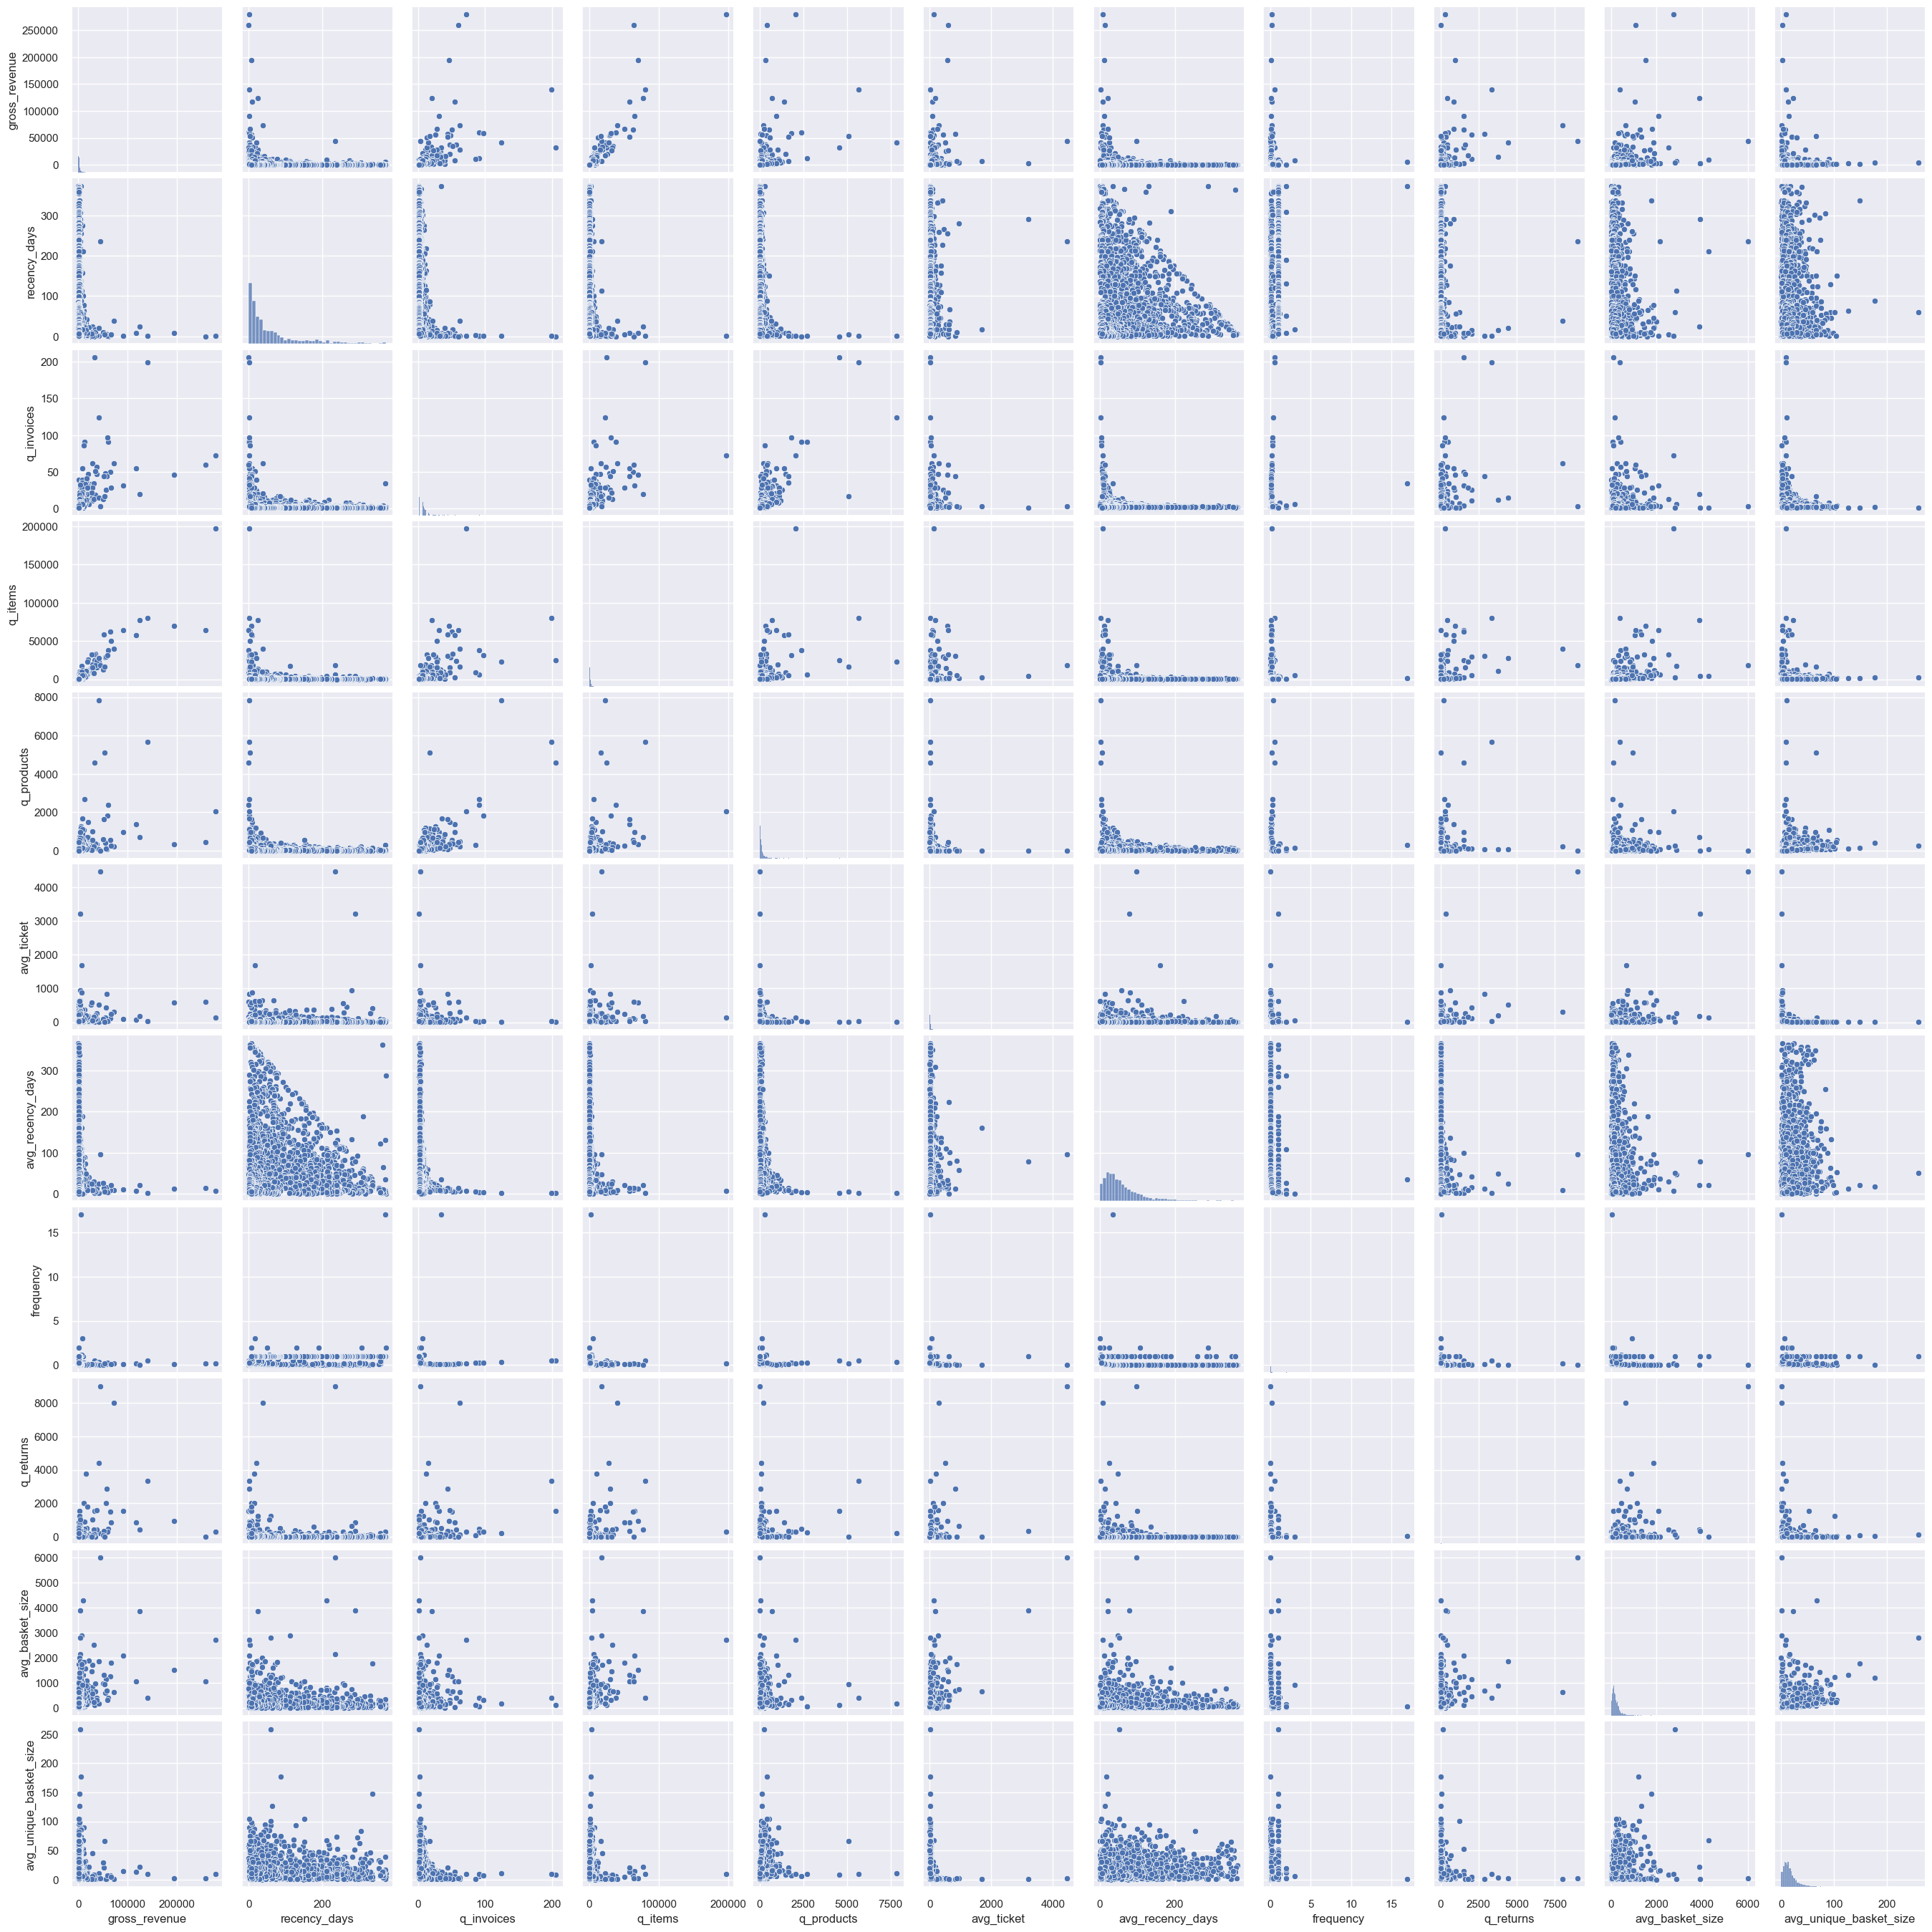

In [47]:
cols = ['customer_id']
df4_2 = df4.drop(cols, axis=1)
plt.figure(figsize=(25, 12));
sns.pairplot(df4_2);

## 5.3. Space Study

In [126]:
# original dataset
#df4_3 = df4.drop(columns='customer_id', axis=1).copy()

# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'q_products', 'frequency', 'q_returns']
df4_3 = df4[cols_selected].copy()

In [127]:
mm = pp.MinMaxScaler()

df4_3['gross_revenue'] = mm.fit_transform(df4_3[['gross_revenue']]) 
df4_3['recency_days'] = mm.fit_transform(df4_3[['recency_days']]) 
#df4_3['q_invoices'] = mm.fit_transform(df4_3[['q_invoices']]) 
#df4_3['q_items'] = mm.fit_transform(df4_3[['q_items']]) 
df4_3['q_products'] = mm.fit_transform(df4_3[['q_products']]) 
#df4_3['avg_ticket'] = mm.fit_transform(df4_3[['avg_ticket']]) 
#df4_3['avg_recency_days'] = mm.fit_transform(df4_3[['avg_recency_days']]) 
df4_3['frequency'] = mm.fit_transform(df4_3[['frequency']]) 
df4_3['q_returns'] = mm.fit_transform(df4_3[['q_returns']]) 
#df4_3['avg_basket_size'] = mm.fit_transform(df4_3[['avg_basket_size']]) 
#df4_3['avg_unique_basket_size'] = mm.fit_transform(df4_3[['avg_unique_basket_size']])

X = df4_3.copy()

### 5.3.1. PCA

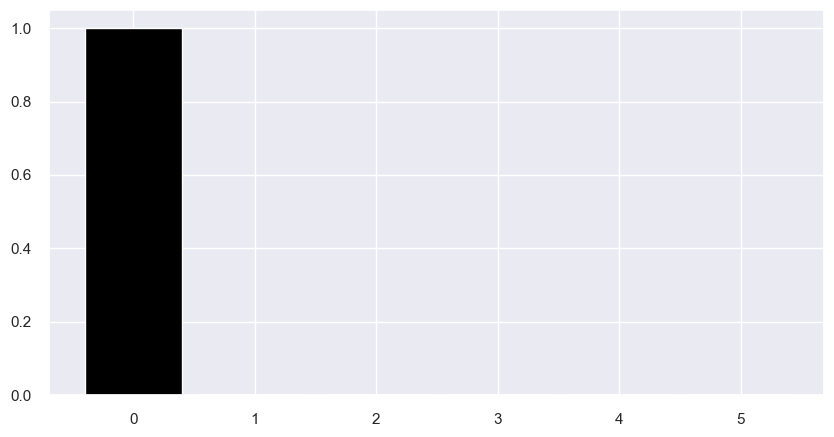

In [128]:
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

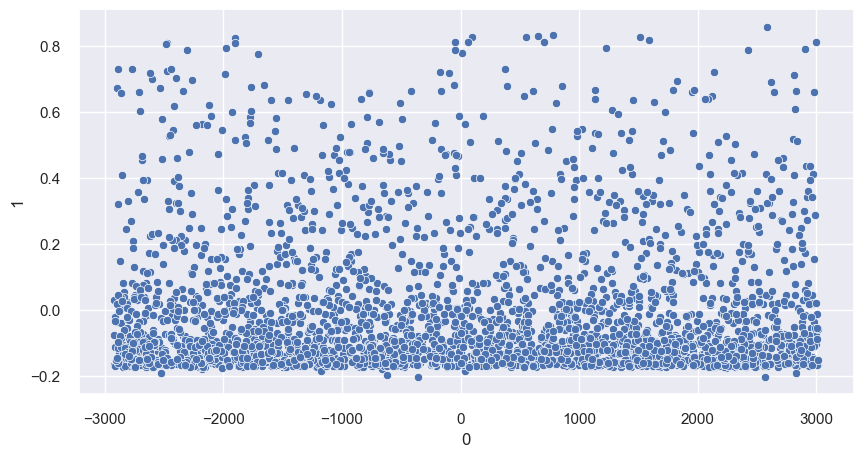

In [129]:
sns.scatterplot(x=0, y=1, data=df_pca);

### 5.3.2. UMAP

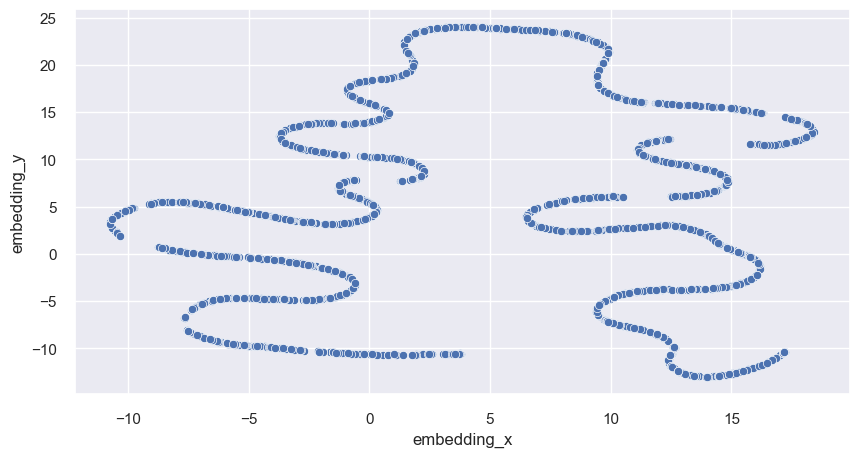

In [130]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca);

### 5.3.3. t-SNE

c:\Users\pma2022\anaconda3\envs\project\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\pma2022\anaconda3\envs\project\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



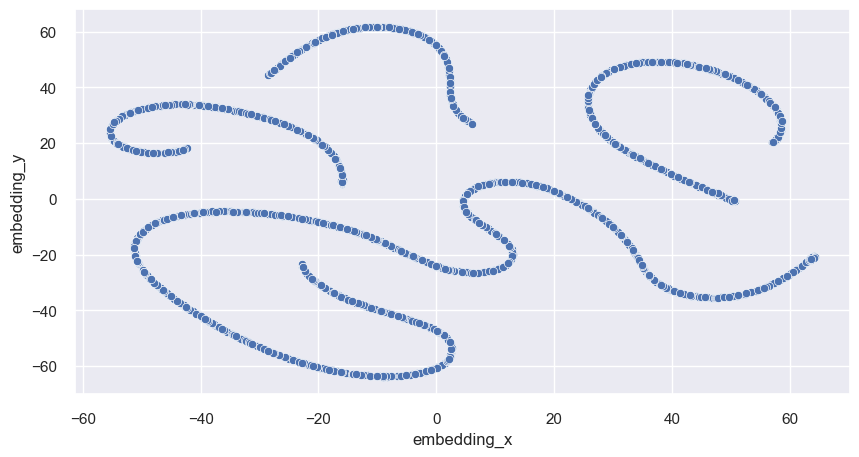

In [131]:
reducer = mn.TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca);

### 5.3.4. Tree-Based Embedding

In [137]:
# training dataset
X = df4_3.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df4_3['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# dataframe leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

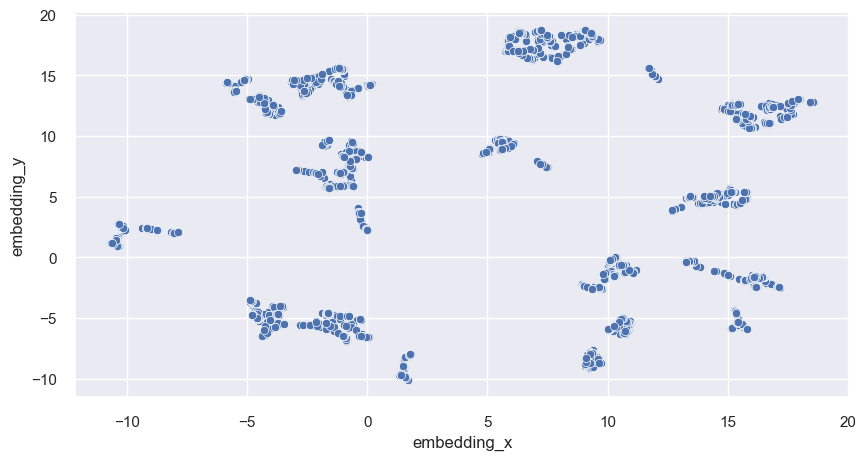

In [138]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

# 6. Data Preparation

In [139]:
df5 = df4_3.copy()
df5_aux = df4_3.copy()
df5_tree = df_tree.copy()

In [140]:
df5.columns 

Index(['customer_id', 'gross_revenue', 'recency_days', 'q_products',
       'frequency', 'q_returns'],
      dtype='object')

- Normal DIstribution with no Outliers -> Standard Scaler - Mean and Standard Deviation
- Normal DIstribution with Outliers -> Robust Scaler - Quartiles
- Not Normal Distribution -> Min Max Scaler

In [151]:
## Standard Scalaer
mm = pp.MinMaxScaler()
ss = pp.StandardScaler()
rs = pp.RobustScaler()

mm_gross_revenue = pp.MinMaxScaler()
mm_recency_days = pp.MinMaxScaler()
mm_q_products = pp.MinMaxScaler()
mm_frequency = pp.MinMaxScaler()
mm_q_returns = pp.MinMaxScaler()

df5['gross_revenue'] = mm_gross_revenue.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = mm_recency_days.fit_transform( df5[['recency_days']] )
#df5['q_invoices'] = mm.fit_transform( df5[['q_invoices']] )
#df5['q_items'] = mm.fit_transform( df5[['q_items']] )
df5['q_products'] = mm_q_products.fit_transform( df5[['q_products']] )
#df5['avg_ticket'] = mm.fit_transform( df5[['avg_ticket']] )
#df5['avg_recency_days'] = mm.fit_transform( df5[['avg_recency_days']] )
df5['frequency'] = mm_frequency.fit_transform( df5[['frequency']] )
df5['q_returns'] = mm_q_returns.fit_transform( df5[['q_returns']] )
#df5['avg_basket_size'] = mm.fit_transform( df5[['avg_basket_size']] )
#df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']] )

variable = 'gross_revenue'

Min:0.0 - Max:1.0


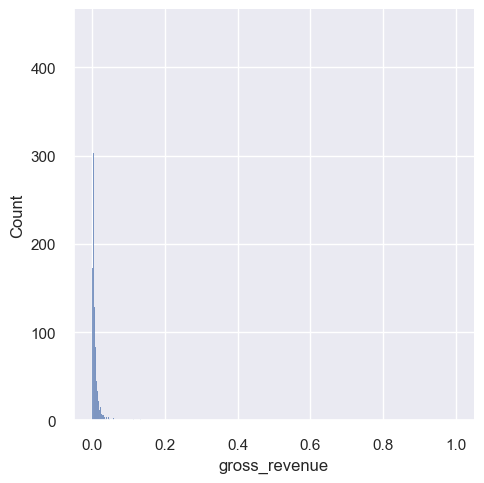

In [152]:
# Data: As Is
print('Min:{} - Max:{}'.format(df5_aux[variable].min(), df5_aux[variable].max()))
sns.displot(df5_aux[variable]);

Min:0.0 - Max:1.0


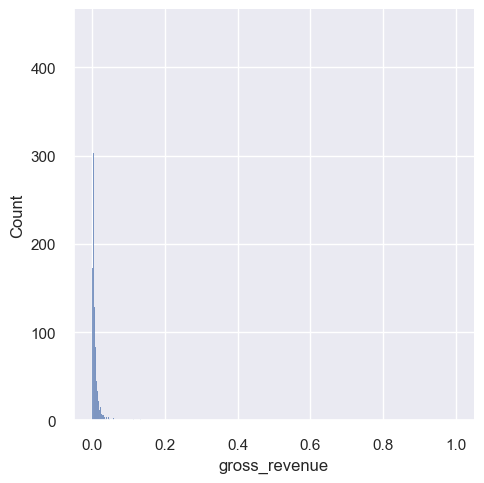

In [153]:
# Data: Normalized/Rescaled
print('Min:{} - Max:{}'.format(df5[variable].min(), df5[variable].max()))
sns.displot(df5[variable]);

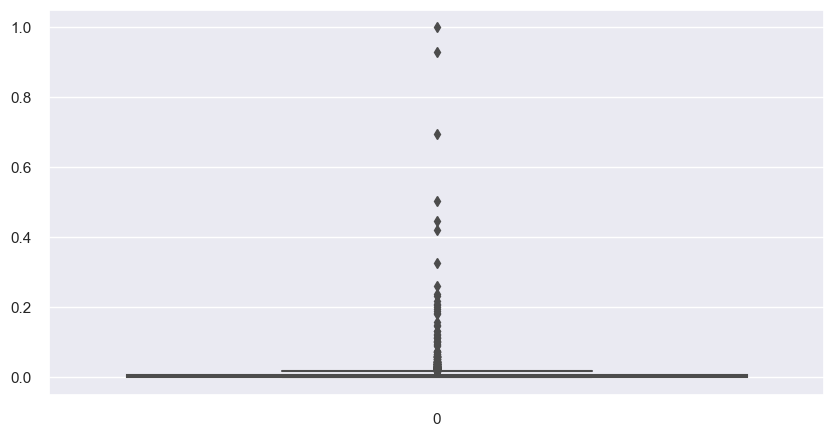

In [154]:
# Boxpĺot
sns.boxplot(df5_aux[variable]);

# 7. Feature Selection

In [157]:
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'q_products', 'frequency', 'q_returns']

In [158]:
df6 = df5[cols_selected].copy()
df6_tree = df5_tree.copy()

# 8. Hyperparameter Fine Tuning

In [160]:
X = df6.drop(columns=['customer_id'])
X_tree = df6_tree.copy()

In [161]:
X.head()

gross_revenue  recency_days  q_products  frequency  q_returns
0         0.0193        0.9973      0.0378     1.0000     0.0044
1         0.0116        0.1501      0.0217     0.0013     0.0039
2         0.0240        0.0054      0.0295     0.0021     0.0055
3         0.0034        0.2547      0.0034     0.0007     0.0000
4         0.0031        0.8928      0.0003     0.0040     0.0024

In [162]:
X_tree.head()

embedding_x  embedding_y
0      -2.1219      -5.4281
1     -10.2590       2.5535
2      -1.4023      -4.7121
3      14.7306       4.5721
4      10.6721      -1.2891

In [204]:
clusters = [2, 3, 4, 5, 6, 7]
clusters_tree = np.arange(2, 21, 1)

## 8.1. K-Means

### 8.1.1. Feature Space

In [170]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters=k)

    # model training
    kmeans_model.fit(X)

    # model predict
    labels = kmeans_model.predict(X)

    # model performance
    sil = metrics.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

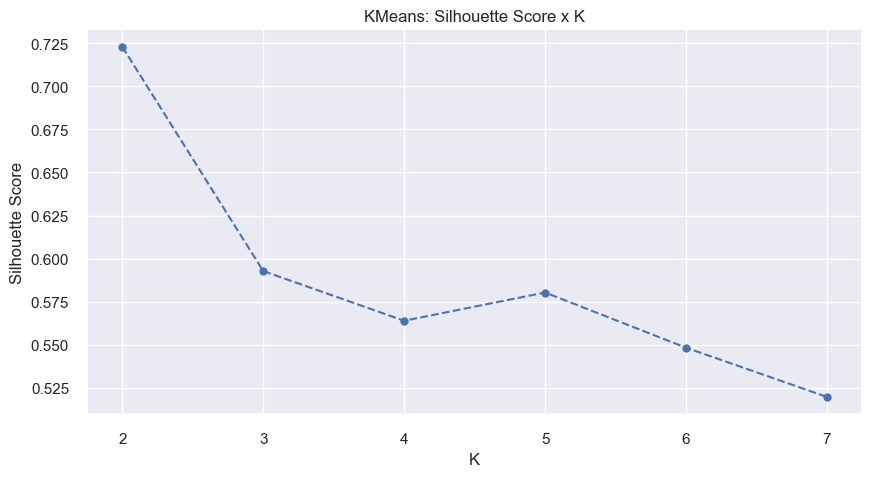

In [172]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('KMeans: Silhouette Score x K');

### 8.1.2. Tree Embedding Space

In [205]:
kmeans_list_tree = []
for k in clusters_tree:
    # model definition
    kmeans_model_tree = c.KMeans(n_clusters=k)

    # model training
    kmeans_model_tree.fit(X_tree)

    # model predict
    labels_tree = kmeans_model_tree.predict(X_tree)

    # model performance
    sil_tree = metrics.silhouette_score(X_tree, labels_tree, metric='euclidean')
    kmeans_list_tree.append(sil_tree)

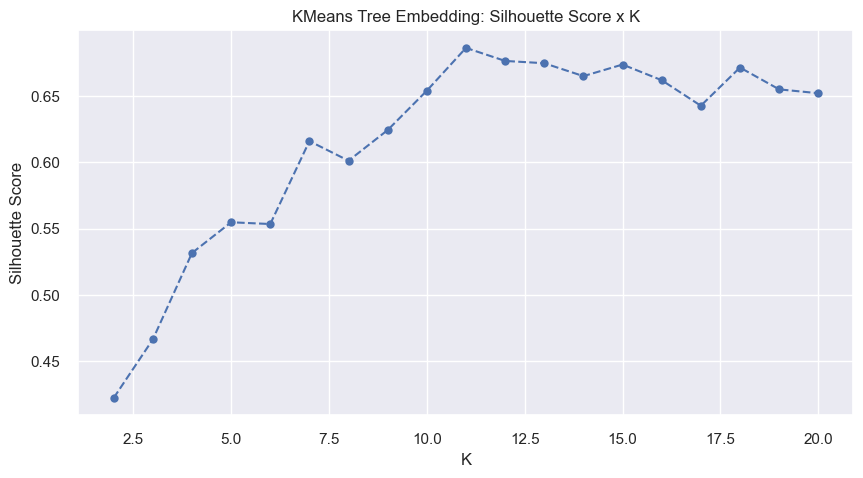

In [206]:
plt.plot(clusters_tree, kmeans_list_tree, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('KMeans Tree Embedding: Silhouette Score x K');

## 8.2. GMM

### 8.2.1. Features Space

In [175]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = metrics.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

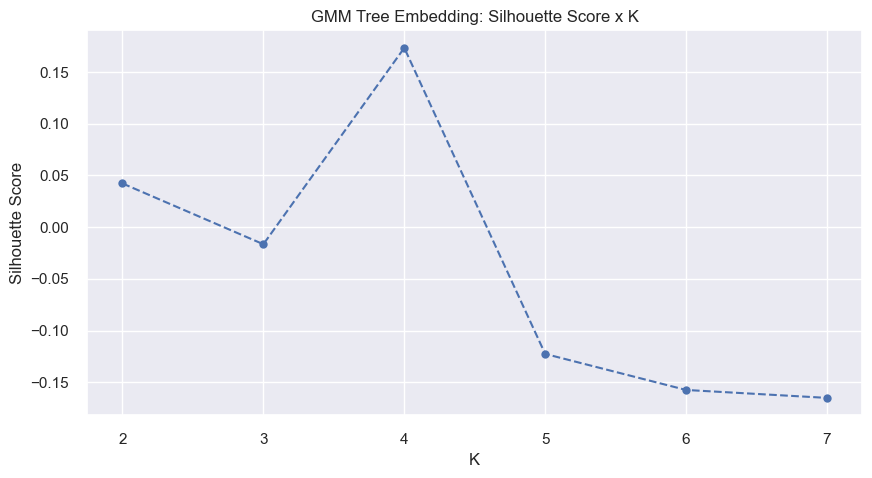

In [176]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('GMM Tree Embedding: Silhouette Score x K');

### 8.2.1. Tree Embedding Space

In [207]:
gmm_list_tree = []
for k in clusters_tree:
    # model definition
    gmm_model_tree = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model_tree.fit(X_tree)

    # model predict
    labels_tree = gmm_model_tree.predict(X_tree)

    # model performance
    sil_tree = metrics.silhouette_score(X_tree, labels_tree, metric='euclidean')
    gmm_list_tree.append(sil_tree)

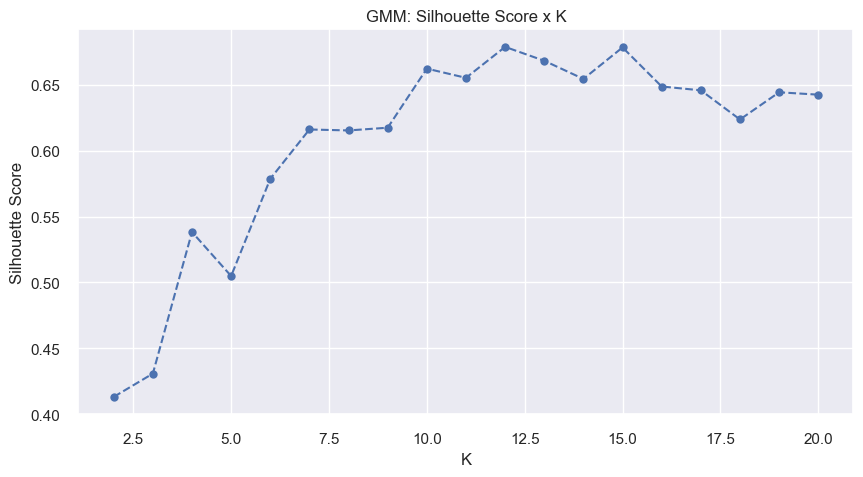

In [208]:
plt.plot(clusters_tree, gmm_list_tree, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('GMM: Silhouette Score x K');

## 8.3. Hierarchical Clustering

### 8.3.1. Features Space

In [179]:
# model definition and training
hc_model = hc.linkage(X, 'ward')

[]

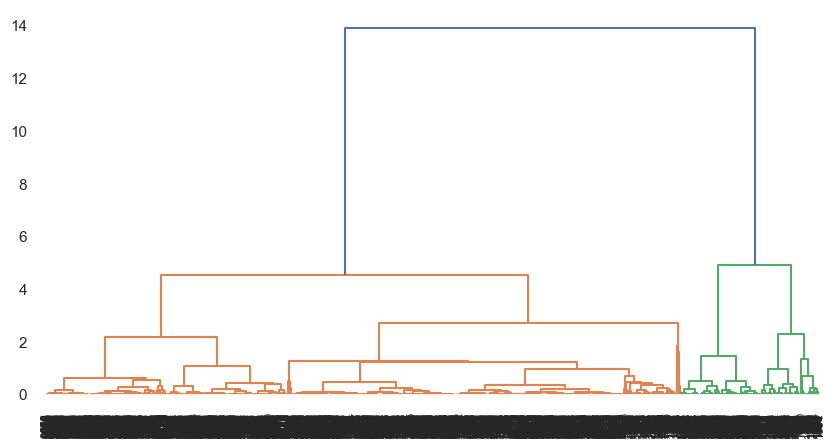

In [180]:
hc.dendrogram(hc_model, leaf_rotation=90, leaf_font_size=8)
plt.plot()

[]

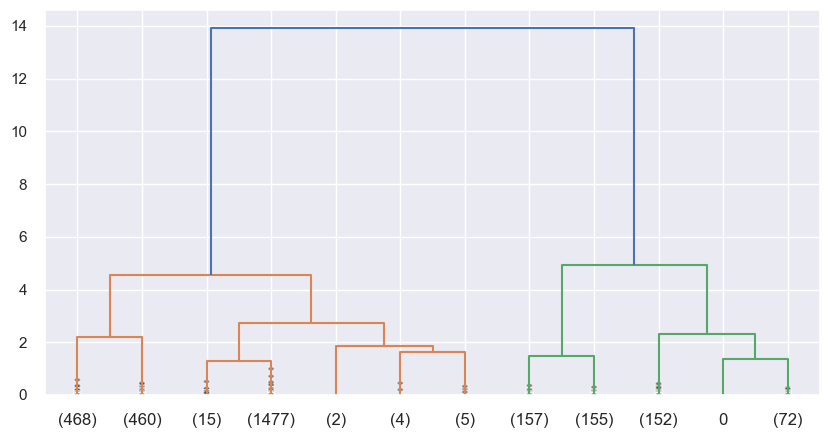

In [181]:
hc.dendrogram(hc_model, truncate_mode='lastp', p=12, show_contracted=True)
plt.plot()

#### 8.3.1.1. Hierarchical Clustering Silhouette Score

In [182]:
hc_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = metrics.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)
    

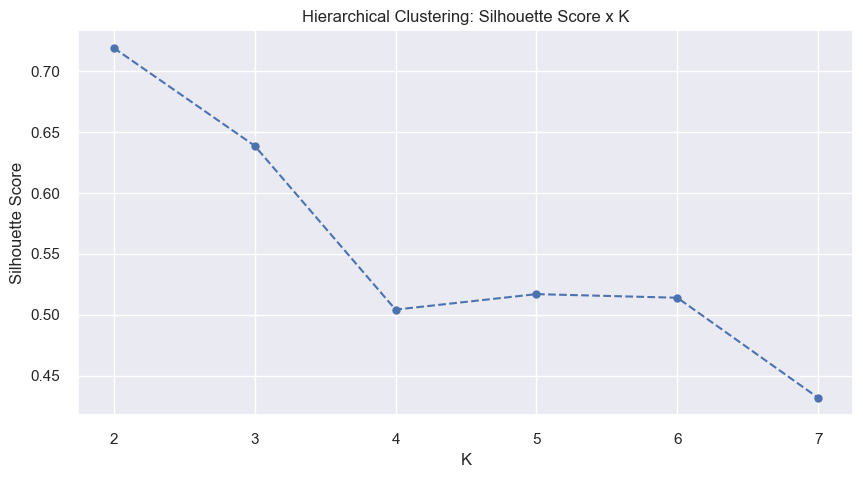

In [183]:
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Hierarchical Clustering: Silhouette Score x K');

### 8.3.2. Tree Embedding Space

In [209]:
# model definition and training
hc_model_tree = hc.linkage(X_tree, 'ward')

[]

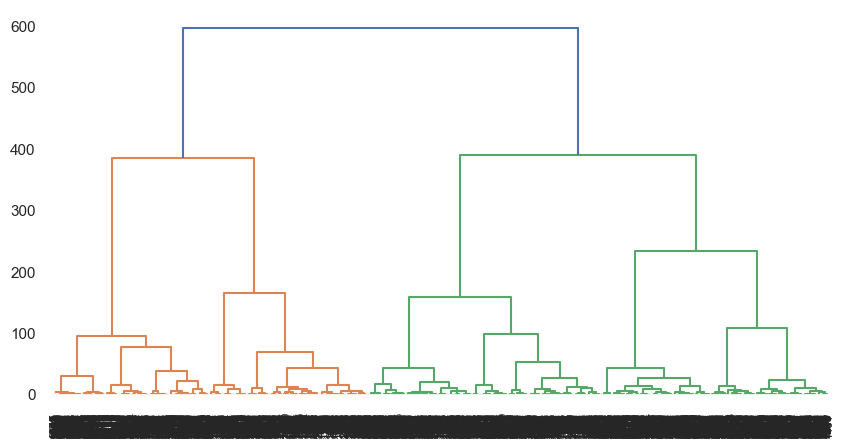

In [210]:
hc.dendrogram(hc_model_tree, leaf_rotation=90, leaf_font_size=8)
plt.plot()

[]

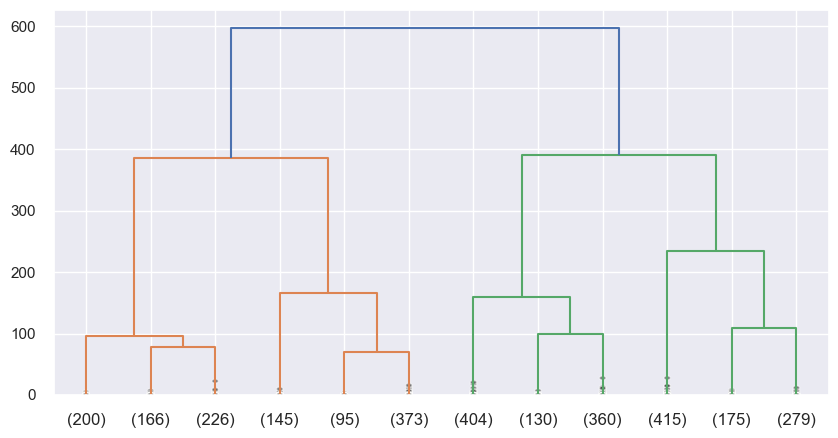

In [211]:
hc.dendrogram(hc_model_tree, truncate_mode='lastp', p=12, show_contracted=True)
plt.plot()

### 8.3.2.1. Hierarchical Clustering Silhouette Score

In [212]:
hc_list_tree = []
for k in clusters_tree:
    # model definition and training
    hc_model_tree = hc.linkage(X_tree, 'ward')

    # model predict
    labels_tree = hc.fcluster(hc_model_tree, k, criterion='maxclust')

    # metrics
    sil_tree = metrics.silhouette_score(X_tree, labels_tree, metric='euclidean')
    hc_list_tree.append(sil_tree)
    

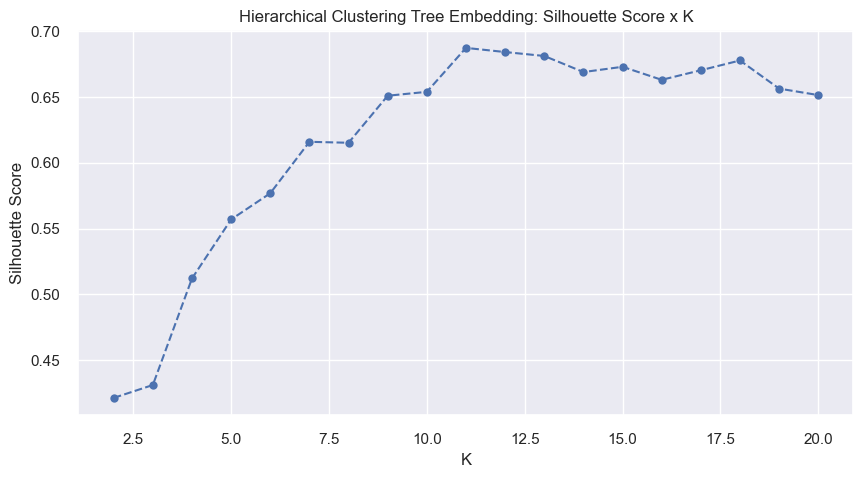

In [213]:
plt.plot(clusters_tree, hc_list_tree, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Hierarchical Clustering Tree Embedding: Silhouette Score x K');

## 8.4. DBSCAN

### 8.4.1. Features Space

In [214]:
eps = 0.01
min_samples = 20

# model definition
dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training and predict
labels = dbscan_model.fit_predict(X)

sil = metrics.silhouette_score(X, labels, metric='euclidean')
print('Silhouette Score: {}'.format(sil))
print('Number of Clusters: {}'.format(len(np.unique(labels))))
print(np.unique(labels))

Silhouette Score: 0.19087687925999902
Number of Clusters: 6
[-1  0  1  2  3  4]


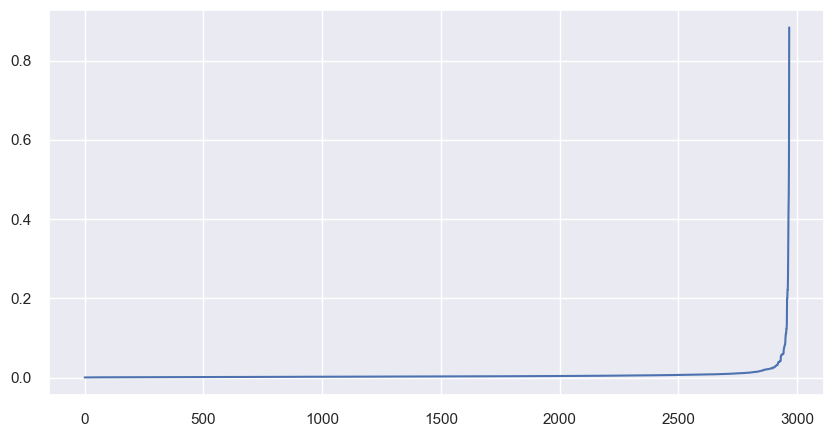

In [215]:
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)

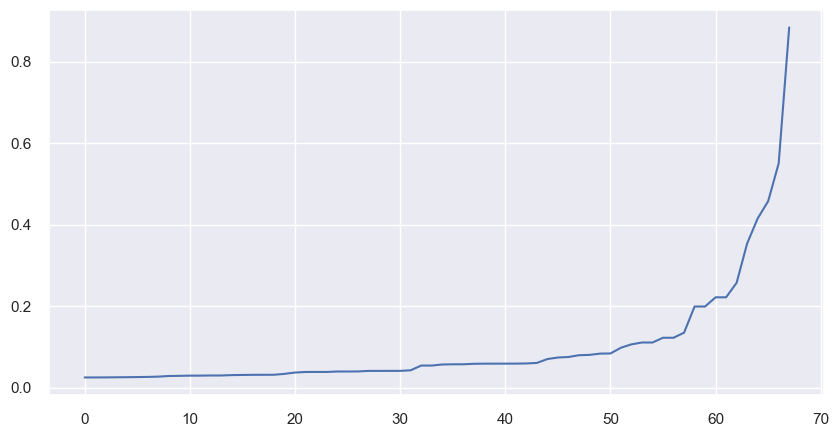

In [216]:
plt.plot(distances[2900:])

In [217]:
dbscan_list = [0.000000, 0.000000, 0.000000, 0.000000, 0.190877, 0.000000]

### 8.4.2. Tree Embedding Space

In [218]:
eps_tree = 2.00
min_samples_tree = 20

# model definition
dbscan_model_tree = c.DBSCAN(eps=eps_tree, min_samples=min_samples_tree)

# model training and predict
labels_tree = dbscan_model_tree.fit_predict(X_tree)

sil_tree = metrics.silhouette_score(X_tree, labels_tree, metric='euclidean')
print('Silhouette Score: {}'.format(sil_tree))
print('Number of Clusters: {}'.format(len(np.unique(labels_tree))))
print(np.unique(labels_tree))

Silhouette Score: 0.6793388724327087
Number of Clusters: 14
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


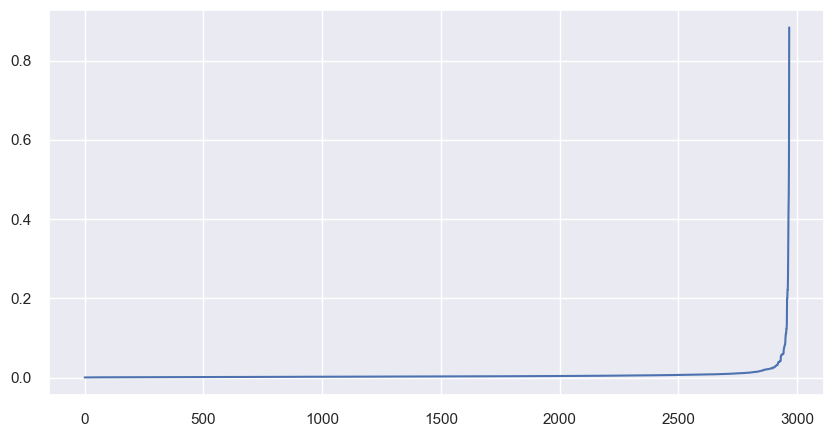

In [219]:
neighbors_tree = NearestNeighbors(n_neighbors=min_samples_tree).fit(X)
distances_tree, indices_tree = neighbors_tree.kneighbors(X)
distances_tree = np.sort(distances_tree, axis=0)
distances_tree = distances_tree[:, 1]
plt.plot(distances_tree)

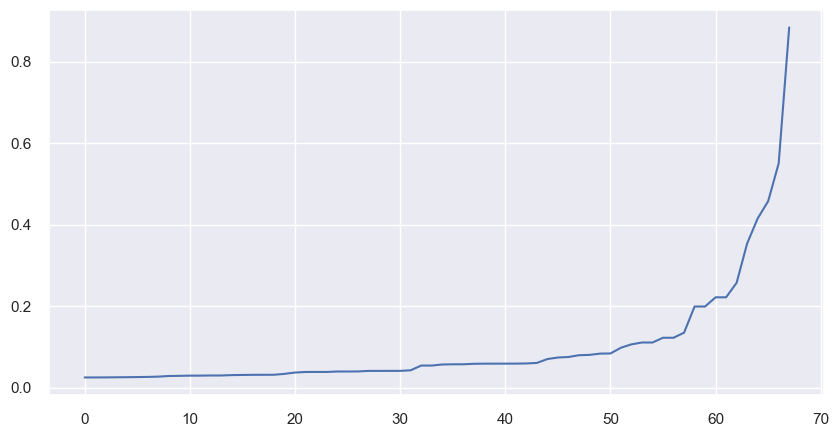

In [220]:
plt.plot(distances_tree[2900:])

In [222]:
dbscan_list_tree = [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 
                    0.000000, 0.000000, 0.679338, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 8.5. Results

### 8.5.1. Features Space

In [223]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list,
     'DBSCAN': dbscan_list}).T

df_results.columns = clusters

In [224]:
df_results.style.highlight_max(color='darkgreen', axis=1)

### 8.5.2. Tree Embedding Space

In [225]:
df_results_tree = pd.DataFrame(
    {'KMeans': kmeans_list_tree,
     'GMM': gmm_list_tree,
     'HC': hc_list_tree,
     'DBSCAN': dbscan_list_tree})#.T

df_results_tree['n_clusters'] = clusters_tree

In [226]:
df_results_tree.style.highlight_max(color='darkgreen', axis=0)

## 8.6. Silhouette Analysis

### 8.6.1. Features Space

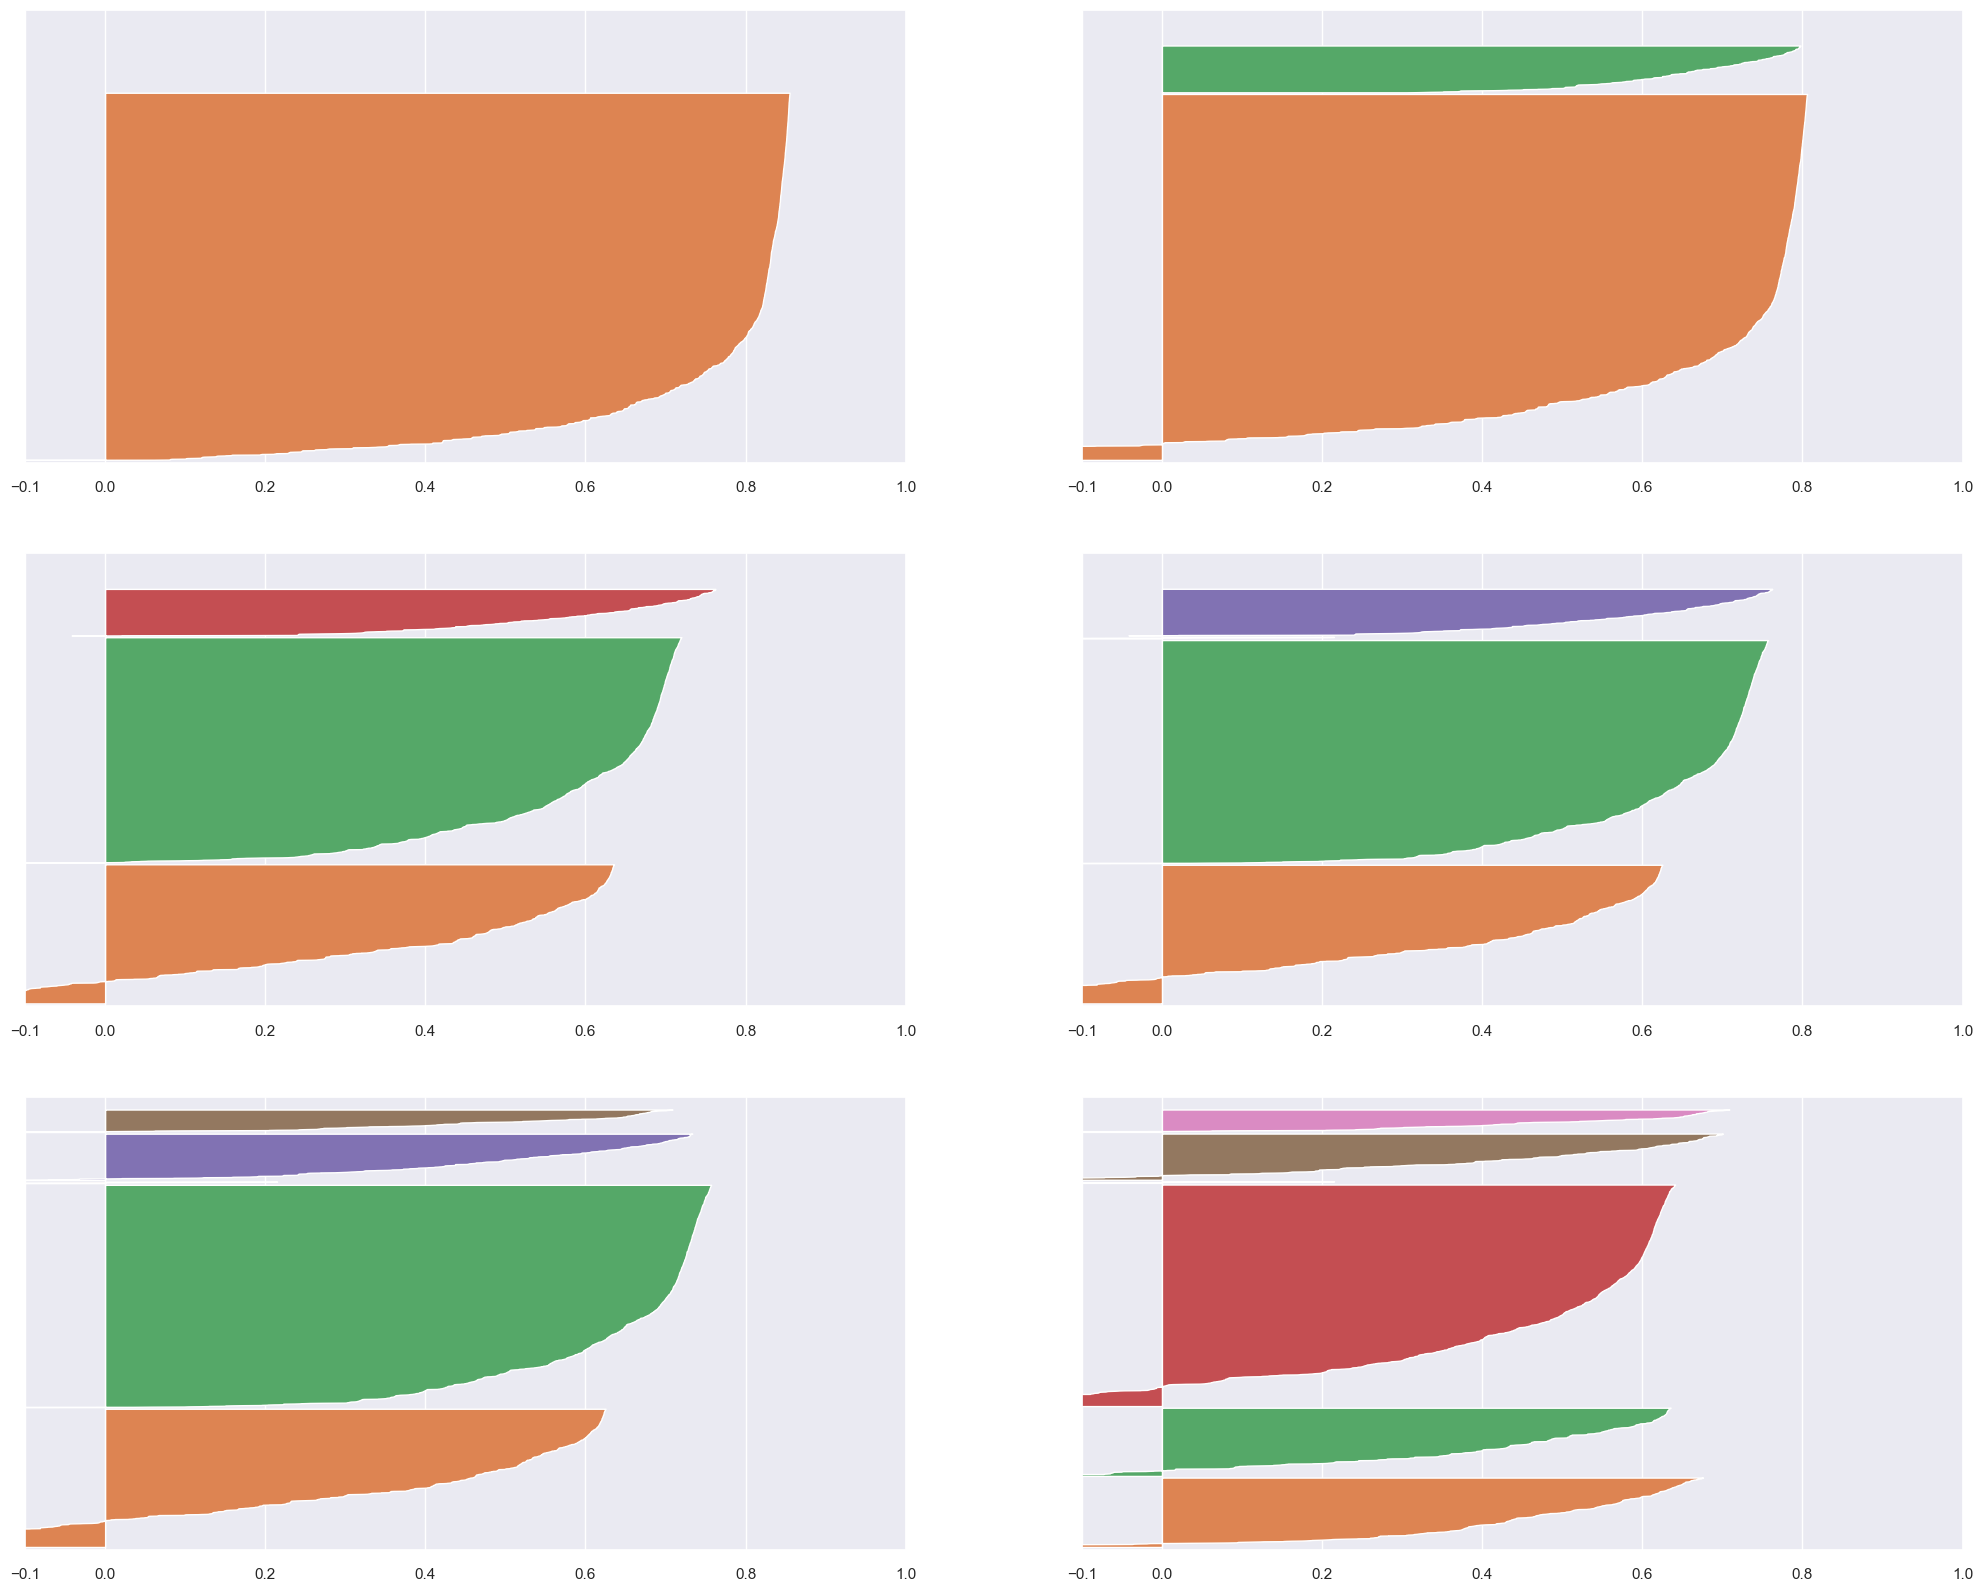

In [203]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(25, 20)

for k in clusters:
    q, mod = divmod(k, 2)
    
    ax[q-1, mod].set_xlim([ -0.1, 1])
    ax[q-1, mod].set_ylim([ 0, len(X) + (k+1)*10])
    
    # model definition & training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # performance
    ss = metrics.silhouette_score(X, labels, metric='euclidean')
    #print('For K = {}. Silhouette Score: {}'.format(k, ss))

    samples_silhouette_values = metrics.silhouette_samples(X, labels)

    y_lower = 10
    for i in range(k):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(i / k)

        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

### 8.6.2. Tree Embedding Space

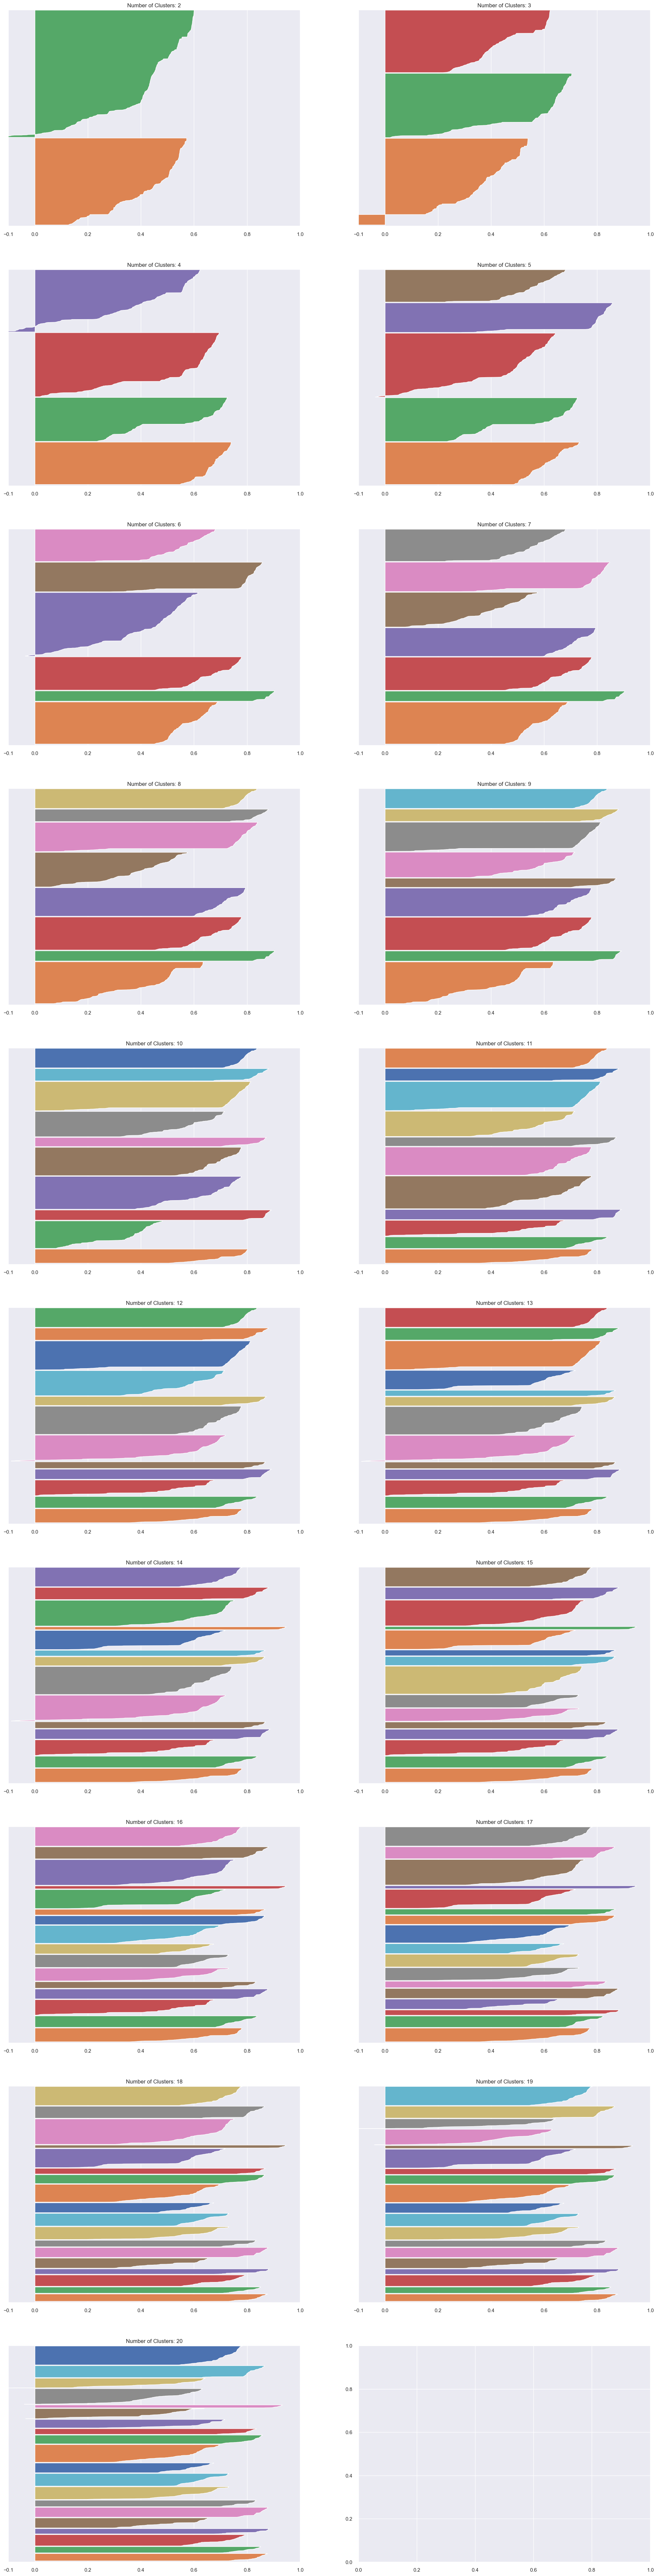

In [230]:
fig, ax = plt.subplots(10, 2)
fig.set_size_inches(25, 100)

for k in clusters_tree:
    q, mod = divmod(k, 2)
    
    ax[q-1, mod].set_xlim([ -0.1, 1])
    ax[q-1, mod].set_ylim([ 0, len(X_tree) + (k+1)*10])
    ax[q-1, mod].set_title('Number of Clusters: {}'.format(k))
    
    # model definition & training
    hc_model_tree = hc.linkage(X_tree, 'ward')

    # model predict
    labels_tree = hc.fcluster(hc_model_tree, k, criterion='maxclust')

    # performance
    ss = metrics.silhouette_score(X_tree, labels_tree, metric='euclidean')
    #print('For K = {}. Silhouette Score: {}'.format(k, ss))

    samples_silhouette_values_tree = metrics.silhouette_samples(X_tree, labels_tree)

    y_lower = 10
    for i in range(k + 1):

        # select clusters
        ith_samples_silhouette_values_tree = samples_silhouette_values_tree[labels_tree == i]
        
        # sort values
        ith_samples_silhouette_values_tree.sort()

        # size clusters
        size_cluster_i_tree = ith_samples_silhouette_values_tree.shape[0]
        y_upper = y_lower + size_cluster_i_tree
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(i / k)

        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values_tree)
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 9. Model Training

## 9.1. K-Means

In [283]:
# model definition
k = 8
kmeans_tree = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans_tree.fit(X_tree)

# clustering
labels_tree_kmeans = kmeans_tree.predict(X_tree)

In [284]:
# WSS
print('WSS Value: {}'.format(kmeans_tree.inertia_))

# SS
print('SS Value: {}'.format(metrics.silhouette_score(X_tree, labels_tree_kmeans, metric='euclidean')))

WSS Value: 28117.97379497521
SS Value: 0.6105068901968431


## 9.2. GMM

In [285]:
# model definition
k = 8
gmm_tree = mx.GaussianMixture(n_components=k)

# model training
gmm_tree.fit(X_tree)

# model predict
labels_tree_gmm = gmm_tree.predict(X_tree)

In [286]:
# WSS
#print('WSS Value: {}'.format(gmm_tree.inertia_))

# SS
print('SS Value: {}'.format(metrics.silhouette_score(X_tree, labels_tree_gmm, metric='euclidean')))

SS Value: 0.6391796557325576


# 10. Cluster Analysis

## 10.1. Features Space

In [287]:
df9 = df4[cols_selected].copy()
df9['cluster'] = labels
df9.head()

customer_id  gross_revenue  recency_days  q_products  frequency  q_returns  cluster
0        17850      5391.2100      372.0000    297.0000    17.0000    40.0000       -1
1        13047      3232.5900       56.0000    171.0000     0.0283    35.0000        0
2        12583      6705.3800        2.0000    232.0000     0.0403    50.0000        0
3        13748       948.2500       95.0000     28.0000     0.0179     0.0000        0
4        15100       876.0000      333.0000      3.0000     0.0732    22.0000       -1

### 10.1.1. 2D Plot

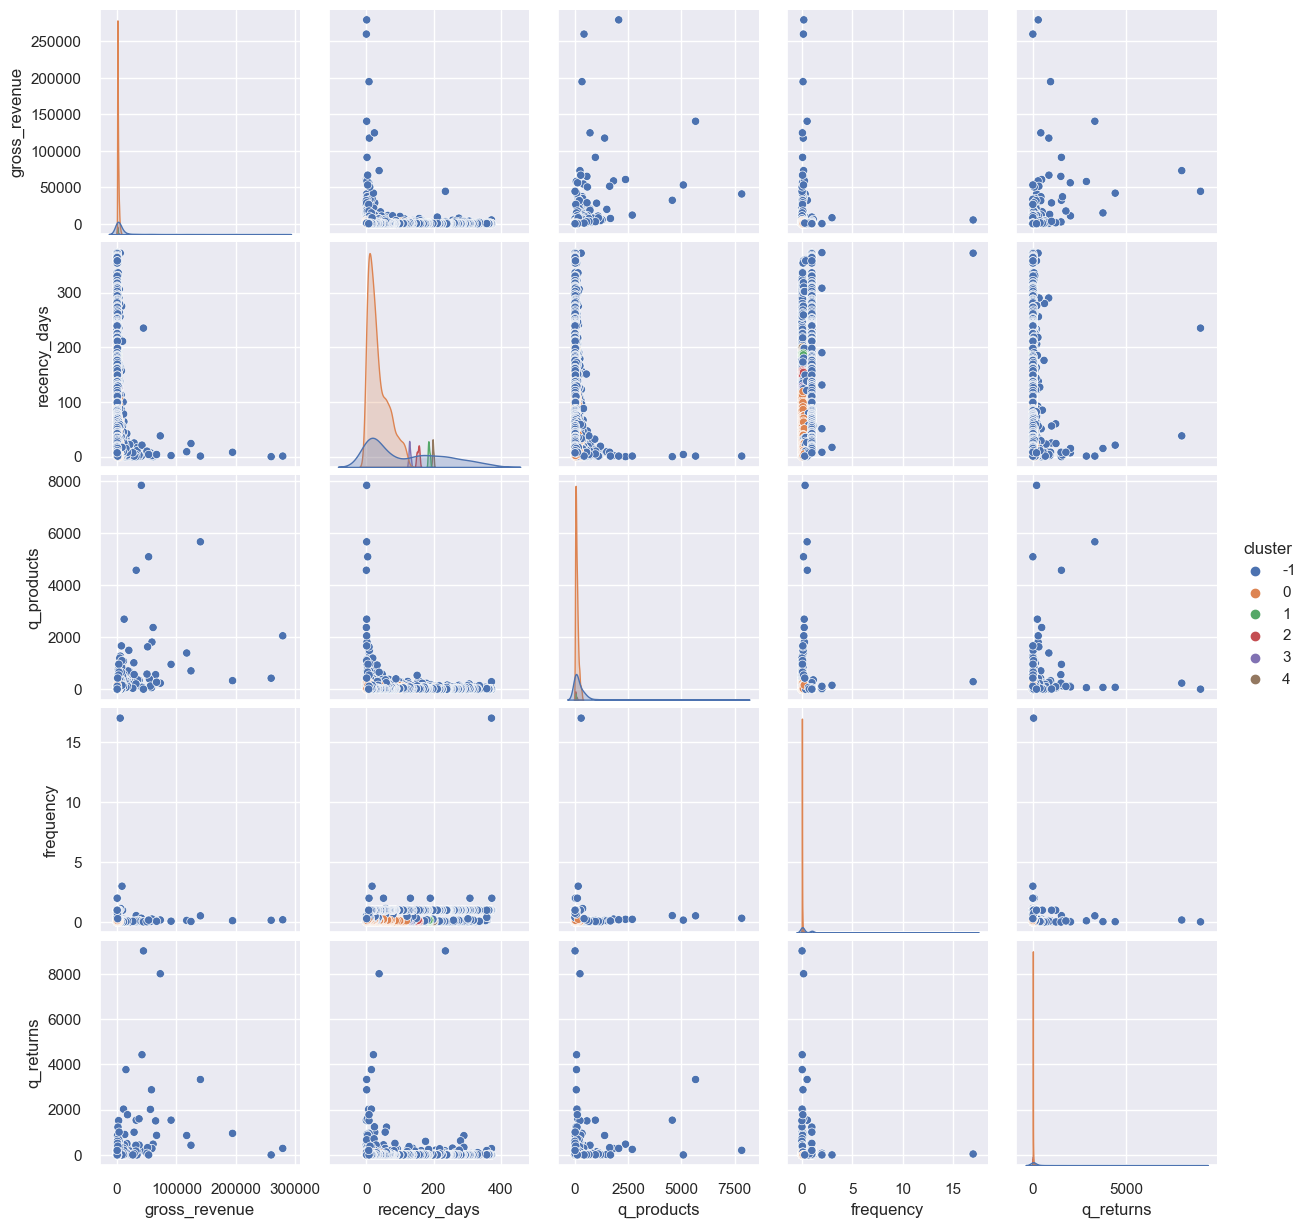

In [288]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster', palette='deep');

### 10.1.2. Cluster Profile

In [290]:
# number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# average gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# average recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# average invoice number
df_avg_invoice_no = df9[['q_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# average frequency
df_avg_invoice_no = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# average returns
df_avg_invoice_no = df9[['q_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

df_cluster

cluster  customer_id  perc_customer  gross_revenue  recency_days  q_products  frequency  q_returns
0       -1          889        29.9528      5607.0749      117.2835    211.5917     0.3081   102.7852
1        0         1962        66.1051      1490.2431       34.3899     87.6442     0.0304     6.0754
2        1           29         0.9771       541.7072      185.6897     33.1724     0.0450     3.3793
3        2           37         1.2466       615.2889      153.5946     34.2703     0.0319     2.0541
4        3           29         0.9771      1091.5583      128.2759     40.0690     0.0324     1.3103
5        4           22         0.7412       695.5782      197.5909     38.8182     0.0384     1.8636

## 10.2. Tree Embedding Space

### 10.2.1. K Means

In [291]:
df9_tree_kmeans = X_tree
df9_tree_kmeans['cluster'] = labels_tree_kmeans

In [292]:
df9_tree_kmeans.head()

embedding_x  embedding_y  cluster
0      -2.1219      -5.4281        4
1     -10.2590       2.5535        3
2      -1.4023      -4.7121        4
3      14.7306       4.5721        7
4      10.6721      -1.2891        5

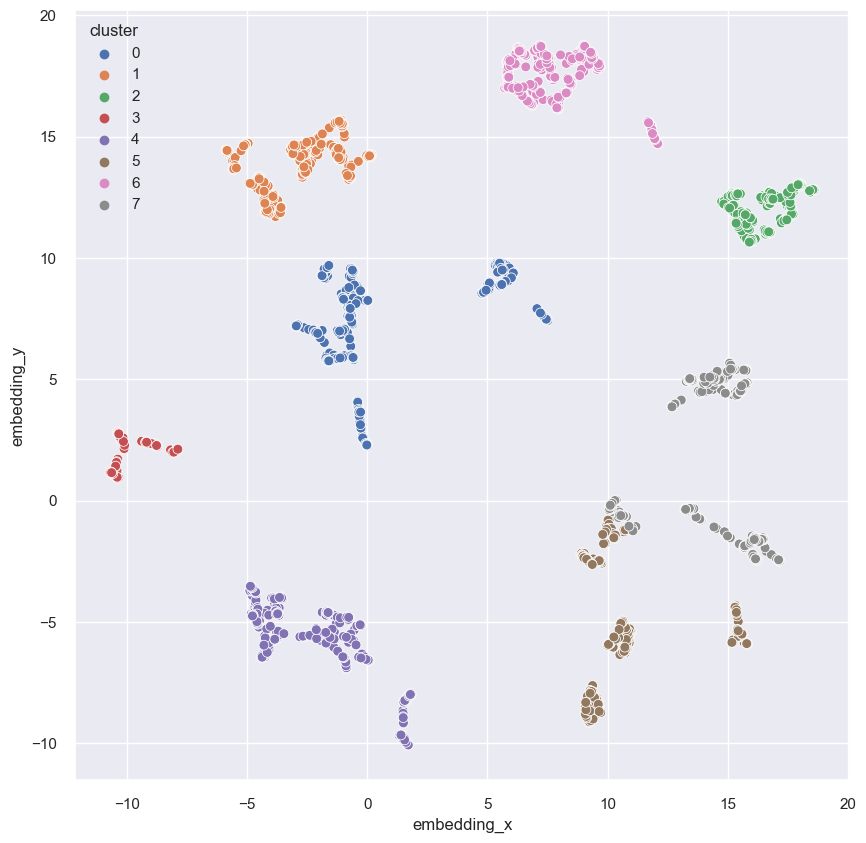

In [293]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9_tree_kmeans, s=50, palette='deep');

### !0.2.2. GMM

In [294]:
df9_tree_gmm = X_tree
df9_tree_gmm['cluster'] = labels_tree_gmm

In [295]:
df9_tree_gmm.head()

embedding_x  embedding_y  cluster
0      -2.1219      -5.4281        2
1     -10.2590       2.5535        7
2      -1.4023      -4.7121        2
3      14.7306       4.5721        0
4      10.6721      -1.2891        4

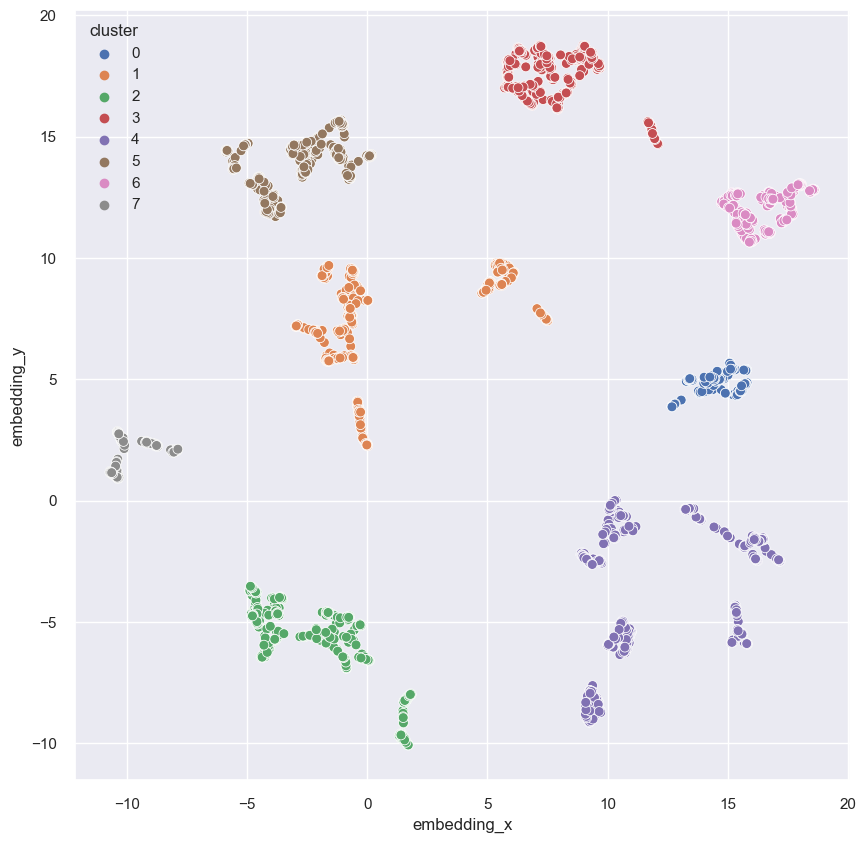

In [296]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9_tree_gmm, s=50, palette='deep');

## 10.3. Clusters Profile

In [301]:
df9_2 = df4[cols_selected].copy()
df9_2['cluster'] = labels_tree_gmm
df9_2.head()

customer_id  gross_revenue  recency_days  q_products  frequency  q_returns  cluster
0        17850      5391.2100      372.0000    297.0000    17.0000    40.0000        2
1        13047      3232.5900       56.0000    171.0000     0.0283    35.0000        7
2        12583      6705.3800        2.0000    232.0000     0.0403    50.0000        2
3        13748       948.2500       95.0000     28.0000     0.0179     0.0000        0
4        15100       876.0000      333.0000      3.0000     0.0732    22.0000        4

In [298]:
# number of customers
df_cluster = df9_2[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# average gross revenue
df_avg_gross_revenue = df9_2[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# average recency days
df_avg_recency_days = df9_2[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# average invoice number
df_avg_invoice_no = df9_2[['q_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# average frequency
df_avg_invoice_no = df9_2[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# average returns
df_avg_invoice_no = df9_2[['q_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

In [300]:
df_cluster.sort_values('gross_revenue', ascending=False)

cluster  customer_id  perc_customer  gross_revenue  recency_days  q_products  frequency  q_returns
2        2          468        15.7682      8835.8971       21.4380    424.0876     0.0946   149.2714
7        7          145         4.8854      3164.1154       34.4276    173.8414     0.0604    23.4828
1        1          490        16.5094      3003.9305       45.9531    120.9163     0.0481    25.2449
5        5          404        13.6119      1689.0735       54.8094     89.1757     0.0500    11.5421
3        3          415        13.9825      1221.4729       61.3711     53.2193     0.0420     9.1229
6        6          279         9.4003       954.0470       77.3620     36.5305     0.0818     5.7097
0        0          175         5.8962       827.4097       92.0229     26.8114     0.1620    22.8686
4        4          592        19.9461       553.6899      114.9172     14.1605     0.2913     6.5389

# 11. EDA (Exploratory Data Analysis)

## 11.1. Hypothesis Mindmap

## 11.2. Business Hypothesis

1. Loyalty program customers use a credit card for 80% of purchases.
2. Loyalty program customers have an average ticket 10% above the More Products cluster
3. Loyalty program customers have a basket size of more than 5 products.
4. The customers of the loyalty program have a purchase volume (products) above 10% of the total purchases.
5. The customers of the loyalty program have a volume (revenue) of purchases above 10% of the total purchases.
6. Loyalty program customers have a lower number of returns than the average of the total customer base.
7. The median billing by loyalty program customers is 10% higher than the median billing overall.
8. Gross merchadise volume percentile by loyalty program customers is on the third quantile.

## 11.3. Final Hypothesis

## 11.4. Hypothesis Validation

# 12. Deployment